In [32]:
# Load libraries
import csv
import matplotlib.pyplot as plt
import statistics
import numpy as np
import os
from IPython.display import clear_output

# k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

import random

In [33]:
# Set filepath
REPOSITORY='/home/ebb505/ARE_Project/are-logs/frontiersMatt04/'
FILENAME='MD_Cart_WDH.csv'
AREPUCKFILEPATH='/home/ebb505/ARE_Project/are-logs/Descriptors2/ARE-Puck/'+FILENAME
AREPOTATOFILEPATH='/home/ebb505/ARE_Project/are-logs/Descriptors2/ARE-Potato/'+FILENAME
ARETRICYCLEFILEPATH='/home/ebb505/ARE_Project/are-logs/Descriptors2/ARE-Tricycle/'+FILENAME
OFILERANDOM='ClusterRandomSelection.csv'
OFILESORTED='ClusterSortedSelection.csv'
print('Filepath: ' + REPOSITORY)

Filepath: /home/ebb505/ARE_Project/are-logs/frontiersMatt04/


In [34]:
# Get all directories
folders = []
# r=root, d=directories, f = files
for r, d, f in os.walk(REPOSITORY):
    for folder in d:
        if(folder[0] == 'l'):
            folders.append(os.path.join(r, folder))
        print(folder)
print("Folders: ", len(folders))

lc_nsms_12_1_17-33-19-9384-725306592
Folders:  1


In [35]:
# Get data evolved robots
my_replicates = []
for f in folders:
    my_list = []
    with open(f + '/' + FILENAME, 'r') as csvfile:
        data = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in data:
            my_list.append(row[:-1]) # Last character is empty for some reason
    my_replicates.append(my_list)
# Hand-made robots
my_robot = []
with open(AREPUCKFILEPATH, 'r') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in data:
        my_robot.append(row[:]) # Last character is empty for some reason        
with open(AREPOTATOFILEPATH, 'r') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in data:
        my_robot.append(row[:]) # Last character is empty for some reason        
with open(ARETRICYCLEFILEPATH, 'r') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in data:
        my_robot.append(row[:]) # Last character is empty for some reason        

In [36]:
POPULATION = 12
#REPLICATES = len(my_replicates)
REPLICATES = 1
#evaluations = len(my_replicates[0])
EVALUATIONS = 5000
FEATURES = len(my_replicates[0][0])
GENERATIONS = int(EVALUATIONS / POPULATION)
interval=1000
rangeValues = range(0,EVALUATIONS,interval)
lenRange = len(rangeValues)
print("Replicates: ", REPLICATES, "Number of evaluations: ", EVALUATIONS, "Features size: ", FEATURES)

Replicates:  1 Number of evaluations:  5000 Features size:  9


In [37]:
# Check all replicates have the minimum number of evaluations
for i in range(REPLICATES):
    print(len(my_replicates[i]))
    if len(my_replicates[i]) < EVALUATIONS:
        print("Error!")


5025


In [38]:
# Process data
repplicates_data = []
for rep in range(REPLICATES):
    tempDat = []
    tempDat = np.array([[float(y) for y in x] for x in my_replicates[rep]]) # Convert to array
    repplicates_data.append(tempDat)
print("Done!")

Done!


In [39]:
# Process data
viableRobots_data = []
for rep in range(REPLICATES):
    copy_rep_data = repplicates_data[rep][:EVALUATIONS]
    tempWheel = copy_rep_data[:,5]>0
    tempSensor = copy_rep_data[:,6]>0
    tempJoint = copy_rep_data[:,7]>0
    viableRobots_data.append(copy_rep_data[(tempWheel|tempJoint)&tempSensor])
    #print(len(repplicates_data[rep][(tempWheel|tempJoint)&tempSensor]))
    #viableRobots_data.append(repplicates_data[rep][tempWheel&tempSensor])

In [40]:
# CLUSTERING
# Example: https://machinelearningmastery.com/clustering-algorithms-with-python/
cluster_robots = []
for rep in range(REPLICATES):
    print(rep/REPLICATES)
    # define the model
    model = KMeans(n_clusters=POPULATION)
    # fit the model
    model.fit(viableRobots_data[rep][:,1:])
    # assign a cluster to each example
    yhat = model.predict(viableRobots_data[rep][:,1:])
    # retrieve unique clusters
    clusters = unique(yhat)
    tempListOfRobots = []
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        #print(len(row_ix[0]))
        tempListOfRobots.append(row_ix[0])
        
    # For random sampling sometimes there is no enough robots to create clusters.
    if len(clusters) < 99:
        for i in range(0,POPULATION-len(clusters),1):
            tempListOfRobots.append(tempListOfRobots[i])
    cluster_robots.append(tempListOfRobots)
    #print(len(tempListOfRobots))

0.0


In [41]:
# Random robot selection
cluster_random = []
for rep in range(REPLICATES):
    temp_rand = []
    for ind in range(POPULATION):
        #print(i)
        clusterSize = len(cluster_robots[rep][ind])
        randInt = random.randint(0,clusterSize-1)
        randInd = cluster_robots[rep][ind][randInt]
        temp_rand.append(randInd)
    cluster_random.append(temp_rand)

In [42]:
# LHS
viable_bootstrap = []
for i in range(REPLICATES):
    #print(i)
    viable_bootstrap.append(viableRobots_data[i][cluster_random[i],0])

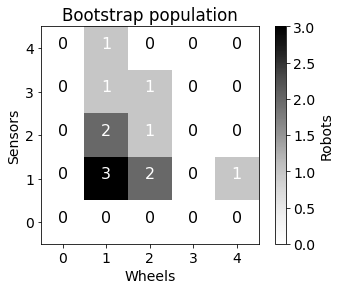

In [43]:
organs = viableRobots_data[0][cluster_random[0],:]
MAXORGANS = 4

font = {'weight' : 'normal',
            'size'   : 14.0}
plt.rc('font', **font)
plt.figure()

INTERVALS =  np.arange(0,1.5,1/MAXORGANS)
xedges = INTERVALS
yedges = INTERVALS

x = []
y = []
for rep in range(REPLICATES):
    x.extend(organs[:,5])
    y.extend(organs[:,6])

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.

for i in range(len(H)):
    for j in range(len(H[i])):
        
        if(H[i,j] > np.max(H)/5):
            plt.text(j*(1/MAXORGANS)+1/(MAXORGANS*2), i*(1/MAXORGANS)+1/(MAXORGANS*2), str(int(H[i,j])), fontsize=16, horizontalalignment='center').set_color('White')
        else:
            plt.text(j*(1/MAXORGANS)+1/(MAXORGANS*2), i*(1/MAXORGANS)+1/(MAXORGANS*2), str(int(H[i,j])), fontsize=16, horizontalalignment='center').set_color('Black')
                

plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Greys')
plt.colorbar(label='Robots')
X, Y = np.meshgrid(xedges, yedges)

plt.xlabel('Wheels')
plt.ylabel('Sensors')

plt.title('Bootstrap population')

TICKPOS =  np.arange(1/(MAXORGANS*2),1.0+1/MAXORGANS,1/MAXORGANS)
TICKLABEL = range(0,1+MAXORGANS,1)
plt.yticks(TICKPOS, [str(i) for i in TICKLABEL])
plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])

plt.savefig(REPOSITORY+'cluster.png',dpi=200, bbox_inches='tight')

In [44]:
# Save to CSV
with open(REPOSITORY + OFILERANDOM, 'w', newline='') as write_obj:
    csv_writer = csv.writer(write_obj)
    for i in range(REPLICATES):
        csv_writer.writerow([int(y) for y in viable_bootstrap[i]])

In [37]:
# Most Sparse robot
cluster_sparse = []
for rep in range(REPLICATES):
    temp_rand = []
    for ind in range(POPULATION):
        temAve = []
        for i in range(len(cluster_robots[rep][ind])):
            temDist = []
            print("Rep: ", rep, " Ind: ", ind, " Size: ", len(cluster_robots[rep][ind]),  " Progress: ", i/len(cluster_robots[rep][ind]))
            for j in range(len(cluster_robots[rep][ind])):
                iInd = cluster_robots[rep][ind][i]
                jInd = cluster_robots[rep][ind][j]
                dist = np.linalg.norm(repplicates_data[rep][iInd][1:]-repplicates_data[rep][jInd][1:])
                temDist.append(dist)
            sortedList = np.sort(temDist)
            temAve.append(np.mean(sortedList[:14]))
            clear_output(wait=True)
        for j in range(len(temAve)):
            if temAve[j] == max(temAve):
                print(j, ': ', cluster_robots[rep][ind][j])
                temp_rand.append(cluster_robots[rep][ind][j])
                break
    cluster_sparse.append(temp_rand)

80 :  1466


In [38]:
# LHS
viable_bootstrap = []
for i in range(REPLICATES):
    #print(i)
    viable_bootstrap.append(viableRobots_data[i][cluster_sparse[i],0])

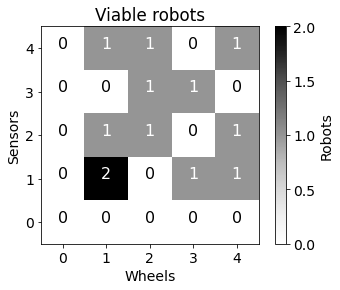

In [39]:
organs = viableRobots_data[0][cluster_sparse[0],:]
MAXORGANS = 4

font = {'weight' : 'normal',
            'size'   : 14.0}
plt.rc('font', **font)
plt.figure()

INTERVALS =  np.arange(0,1.5,1/MAXORGANS)
xedges = INTERVALS
yedges = INTERVALS

x = []
y = []
for rep in range(REPLICATES):
    x.extend(organs[:,5])
    y.extend(organs[:,6])

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.

for i in range(len(H)):
    for j in range(len(H[i])):
        
        if(H[i,j] > np.max(H)/5):
            plt.text(j*(1/MAXORGANS)+1/(MAXORGANS*2), i*(1/MAXORGANS)+1/(MAXORGANS*2), str(int(H[i,j])), fontsize=16, horizontalalignment='center').set_color('White')
        else:
            plt.text(j*(1/MAXORGANS)+1/(MAXORGANS*2), i*(1/MAXORGANS)+1/(MAXORGANS*2), str(int(H[i,j])), fontsize=16, horizontalalignment='center').set_color('Black')
                

plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Greys')
plt.colorbar(label='Robots')
X, Y = np.meshgrid(xedges, yedges)

plt.xlabel('Wheels')
plt.ylabel('Sensors')

plt.title('Viable robots')

TICKPOS =  np.arange(1/(MAXORGANS*2),1.0+1/MAXORGANS,1/MAXORGANS)
TICKLABEL = range(0,1+MAXORGANS,1)
plt.yticks(TICKPOS, [str(i) for i in TICKLABEL])
plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])

plt.savefig(REPOSITORY+'cluster.png',dpi=200, bbox_inches='tight')

In [40]:
# Save to CSV
with open(REPOSITORY + OFILESORTED, 'w', newline='') as write_obj:
    csv_writer = csv.writer(write_obj)
    for i in range(REPLICATES):
        csv_writer.writerow([int(y) for y in viable_bootstrap[i]])